### Import of necessary packages

In [1]:
import tweepy as tw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import RegexpTokenizer, WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from string import punctuation
import collections
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import en_core_web_sm
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_similarity_score

### 1. Authenticate to Twitter


In [2]:
consumer_key="WtB3bpjoXVBYV3Z3rbdF1h8iU"
consumer_secret="YdZnRnvX2QxiaB8iRJnvGO0vHs8OgQCXa90BsSAa0JrhD541XV"
access_token="1331556108184457218-XFFtIDeaBpF3W1MgTiqlamAeqZvzav"
access_token_secret="5QkbZnPSd4dWmp1TDBqkFK6T1n96T9Wtv30IxB9hjhIPj"

In [3]:
# Authenticate
auth = tw.OAuthHandler(consumer_key, consumer_secret)
# Set Tokens
auth.set_access_token(access_token, access_token_secret)
# Instantiate API
api = tw.API(auth, wait_on_rate_limit=True)

In [4]:
hashtag = "#news"
query = tw.Cursor(api.search, q=hashtag).items(10000)
tweets = [{'Tweet':tweet.text, 'Timestamp':tweet.created_at} for tweet in query]
print(tweets)

[{'Tweet': 'औरंगाबाद में चाय से लेकर मधु, मशरुम व फ्रूट प्रोसेसिंग की लगेगी यूनिट\n\nhttps://t.co/MadDL0At6v\n\n#LocalNews  #news… https://t.co/u8C2iNEAVO', 'Timestamp': datetime.datetime(2020, 12, 14, 19, 4, 59)}, {'Tweet': 'RT @PSUdotcom: PlayStation Support Is Reportedly Denying Cyberpunk 2077 Refund Requests After CD Projekt Red Says People Can Get Them\nhttps…', 'Timestamp': datetime.datetime(2020, 12, 14, 19, 4, 54)}, {'Tweet': 'RT @CancilleriaVE: #NEWS | Delegations from Kenya and the Congo visit the Center for African, American and Caribbean Knowledge in Caracas…', 'Timestamp': datetime.datetime(2020, 12, 14, 19, 4, 38)}, {'Tweet': 'RT @eStream_Studios: EA Reportedly In Talks To Buy Codemasters, Could Cut Out Take-Two: A little over a month ago, publisher Take-Two annou…', 'Timestamp': datetime.datetime(2020, 12, 14, 19, 4, 32)}, {'Tweet': 'RT @MikeCampese: For the latest MC news, click the link.  https://t.co/GeyGA4mKg7 #🎸#🎶 #mikecampese #news #christmas #christmasmusic #holid

In [5]:
tweets = pd.DataFrame.from_dict(tweets)
tweets.head()

,Timestamp,Tweet
0,2020-12-14 19:04:59,"औरंगाबाद में चाय से लेकर मधु, मशरुम व फ्रूट प्..."
1,2020-12-14 19:04:54,RT @PSUdotcom: PlayStation Support Is Reported...
2,2020-12-14 19:04:38,RT @CancilleriaVE: #NEWS | Delegations from Ke...
3,2020-12-14 19:04:32,RT @eStream_Studios: EA Reportedly In Talks To...
4,2020-12-14 19:04:24,"RT @MikeCampese: For the latest MC news, click..."


### Tweets Cleaning

In [6]:
# Remove the hashtags, mentions and unwanted characters.
def clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"        (@[0–9]+)|([0-9\t])|(\w+:\/\/s\S+)|^rt|@|#|http.+?", "",   elem)) 
    return df
tweets_bowl = clean_text(tweets, 'Tweet')
tweets_bowl.head()

,Timestamp,Tweet
0,2020-12-14 19:04:59,"औरंगाबाद में चाय से लेकर मधु, मशरुम व फ्रूट प्..."
1,2020-12-14 19:04:54,psudotcom: playstation support is reportedly ...
2,2020-12-14 19:04:38,cancilleriave: news | delegations from kenya ...
3,2020-12-14 19:04:32,estream_studios: ea reportedly in talks to bu...
4,2020-12-14 19:04:24,"mikecampese: for the latest mc news, click th..."


###  Tokenization, Lemmatization and removing stopwords

In [8]:
nlp = en_core_web_sm.load() 
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation) #already taken care of with the cleaning function.
stop.update(punctuation)
w_tokenizer = WhitespaceTokenizer()
def furnished(text):
    final_text = []
    for i in w_tokenizer.tokenize(text):
        if i.lower() not in stop:
            word = lemmatizer.lemmatize(i)
            final_text.append(word.lower())
    return "".join(final_text)
tweets_bowl.Tweet = tweets_bowl.Tweet.apply(furnished)

In [9]:
tweets_bowl.head()

,Timestamp,Tweet
0,2020-12-14 19:04:59,"औरंगाबादमेंचायसेलेकरमधु,मशरुमवफ्रूटप्रोसेसिंगक..."
1,2020-12-14 19:04:54,psudotcom:playstationsupportreportedlydenyingc...
2,2020-12-14 19:04:38,cancilleriave:newsdelegationkenyacongovisitcen...
3,2020-12-14 19:04:32,estream_studios:eareportedlytalkbuycodemasters...
4,2020-12-14 19:04:24,"mikecampese:latestmcnews,clicklink.://t.co/gey..."


### Tweets Classification

In [10]:
economy_related_words = "agriculture infrastructure capitalism trading service sector technology  economical supply industrialism efficiency frugality retrenchment downsizing   credit debit value economize   save  economically economies sluggish rise   rising spending conserve trend low-management  decline   industry impact poor  profession    surplus   fall declining  accelerating interest sectors balance stability productivity increase rates pushing expanding stabilize  rate industrial borrowing strugglingdeficit predicted    increasing  data economizer analysts investment market-based economy   debt free enterprise medium  exchange metric savepoint scarcity capital bank company stockholder fund business asset treasury tourism incomes contraction employment jobs upturn deflation  macroeconomics bankruptcies exporters hyperinflation dollar entrepreneurship upswing marketplace commerce devaluation quicksave deindustrialization stockmarket reflation downspin dollarization withholder bankroll venture capital mutual fund plan economy mortgage lender unemployment rate credit crunch central bank financial institution bank rate custom duties mass-production black-market developing-countries developing economic-growth gdp trade barter distribution downturn economist"

In [11]:
sport_related_words ="aerobics archer archery arena arrow athlete athletics axel badminton ball base baseball basketball bat baton batter batting biathlon bicycle bicycling bike biking billiards bobsleigh bocce boomerang boules bowbowler bowling boxer boxing  bronze medalbunt karate kayak kayaker kayaking kickball kite kneepads kung fu paddle paddleball paddling paintball parasailing parkour pentathlon pickleball ping pong pitch pitcher play player playing playoffs pogostick polepolevault polopool puck " 

In [12]:
health_related_words="fitness healthiness heartiness robustness sap soundness verdure wellness wholeness wholesomeness fettle shape cleanliness hygienehardiness lustiness robustiousness ruggedness stamina strength toughness vigor vigorousness vitalitybloom flush flushness activeness agility liveliness spryness weal welfare well-being debility decrepitude feebleness frailness infirmity lameness sickliness weakness ailment condition disease disorder malady trouble practice pass phase stage footing picture posture scene situation status rank standing"

In [13]:
social_related_words=" boon clubbable clubby companionable convivial extroverted gregarious outgoing sociable Words Related to social cordial folksy forthcoming friendly hospitable affable genial graciousagreeable amiable congenial kindly neighborly animated jaunty jolly jovial lively peppy perky pert spirited sprightful sprightly vivacious communicative expansive garrulous talkative"

  

In [14]:
economy = furnished(economy_related_words)
social = furnished(social_related_words)
sport = furnished(sport_related_words)
health = furnished(health_related_words)

In [15]:
string1 = economy
words = string1.split()
economy = " ".join(sorted(set(words), key=words.index))
economy
string1 = social
words = string1.split()
social = " ".join(sorted(set(words), key=words.index))
social
string1 = health
words = string1.split()
health = " ".join(sorted(set(words), key=words.index))
health
string1 = sport
words = string1.split()
sport = " ".join(sorted(set(words), key=words.index))
sport

'aerobicsarcherarcheryarenaarrowathleteathleticsaxelbadmintonballbasebaseballbasketballbatbatonbatterbattingbiathlonbicyclebicyclingbikebikingbilliardsbobsleighbocceboomerangboulebowbowlerbowlingboxerboxingbronzemedalbuntkaratekayakkayakerkayakingkickballkitekneepadskungfupaddlepaddleballpaddlingpaintballparasailingparkourpentathlonpickleballpingpongpitchpitcherplayplayerplayingplayoffpogostickpolepolevaultpolopoolpuck'

### Jaccard  Similarity Scores

In [16]:
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return len(intersection)/len(union)
def get_scores(group,tweets):
    scores = []
    for tweet in tweets:
        s = jaccard_similarity(group, tweet)
        scores.append(s)
    return scores
e_scores = get_scores(economy, tweets_bowl.Tweet.to_list())
s_scores = get_scores(social, tweets_bowl.Tweet.to_list())
s_scores = get_scores(sport, tweets_bowl.Tweet.to_list())
h_scores = get_scores(health, tweets_bowl.Tweet.to_list())

### Clustered Data Frame

In [47]:
# create a jaccard scored df.
data  = {'Time':tweets_bowl.Timestamp.to_list(),       'economic_score':e_scores,
         'social_score': s_scores, 'sport_score':s_scores, 'health_scores':h_scores}
scores_df = pd.DataFrame(data)
#assign classes based on highest score
def get_classes(l1, l2, l3, l4):
    econ = []
    socio = []
    spo = []
    heal = []
    for i, j, k, l in zip(l1, l2, l3, l4):
        m = max(i, j, k, l)
        if m == i:
            econ.append(1)
        else:
            econ.append(0)
        if m == j:
            socio.append(1)
        else:
            socio.append(0)        
        if m == k:
            spo.append(1)
        else:
            spo.append(0)  
        if m == l:
            heal.append(1)
        else:
            heal.append(0)   
            
    return econ, socio, spo, heal
l1 = scores_df.economic_score.to_list()
l2 = scores_df.social_score.to_list()
l3 = scores_df.sport_score.to_list()
l4 = scores_df.health_scores.to_list()
econ, socio, spo, heal = get_classes(l1, l2, l3, l4)
data = {'Time': scores_df.Time.to_list(), 'economic':econ, 'social':socio, 'sport':spo, 'health': heal}
class_df = pd.DataFrame(data)
#grouping the tweets by username
new_groups_df = class_df.groupby(['Time']).sum()
#add a new totals column
new_groups_df['total'] = new_groups_df['health'] + new_groups_df['sport'] + new_groups_df['social'] +  new_groups_df['economic']
#add a new totals row
new_groups_df.loc["Total"] = new_groups_df.sum()  

In [48]:
print(new_groups_df)

                     economic  social  sport  health  total
Time                                                       
2020-12-14 17:10:30         0       0      0       1      1
2020-12-14 17:10:33         0       1      1       0      2
2020-12-14 17:10:48         0       1      1       0      2
2020-12-14 17:11:01         0       2      2       0      4
2020-12-14 17:11:03         0       0      0       1      1
2020-12-14 17:11:11         1       0      0       1      2
2020-12-14 17:11:18         0       1      1       1      3
2020-12-14 17:11:19         0       1      1       0      2
2020-12-14 17:11:24         0       1      1       0      2
2020-12-14 17:11:26         0       0      0       2      2
2020-12-14 17:11:29         0       1      1       1      3
2020-12-14 17:11:31         0       0      0       1      1
2020-12-14 17:11:33         0       2      2       0      4
2020-12-14 17:11:34         1       1      1       0      3
2020-12-14 17:11:44         0       1   

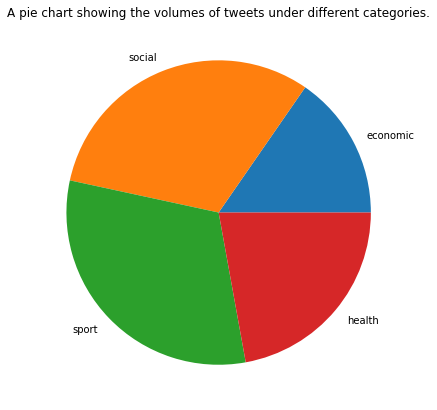

In [49]:
fig = plt.figure(figsize =(10, 7)) 
a = new_groups_df.drop(['total'], axis = 1)
plt.pie(a.loc['Total'], labels = a.columns)
plt.title('A pie chart showing the volumes of tweets under different categories.')
plt.show()

### KMeans Clustering

In [53]:
new_groups_df.drop(new_groups_df.tail(1).index,inplace=True) # drop last n rows
print(new_groups_df)
X=new_groups_df.iloc[: , 0:4].values

print(X)




                     economic  social  sport  health  total
Time                                                       
2020-12-14 17:10:30         0       0      0       1      1
2020-12-14 17:10:33         0       1      1       0      2
2020-12-14 17:10:48         0       1      1       0      2
2020-12-14 17:11:01         0       2      2       0      4
2020-12-14 17:11:03         0       0      0       1      1
2020-12-14 17:11:11         1       0      0       1      2
2020-12-14 17:11:18         0       1      1       1      3
2020-12-14 17:11:19         0       1      1       0      2
2020-12-14 17:11:24         0       1      1       0      2
2020-12-14 17:11:26         0       0      0       2      2
2020-12-14 17:11:29         0       1      1       1      3
2020-12-14 17:11:31         0       0      0       1      1
2020-12-14 17:11:33         0       2      2       0      4
2020-12-14 17:11:34         1       1      1       0      3
2020-12-14 17:11:44         0       1   

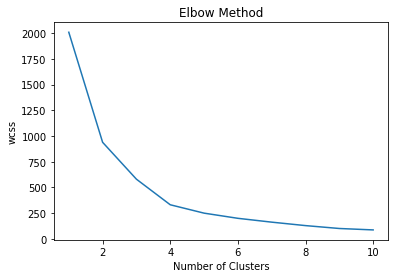

In [54]:
# Elbow Method
from sklearn.cluster import KMeans
wcss  = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.show()

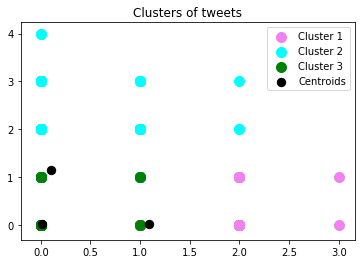

In [55]:
# fitting kmeans to dataset
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=0)
Y_kmeans = kmeans.fit_predict(X)
# Visualising the clusters
plt.scatter(X[Y_kmeans==0, 0], X[Y_kmeans==0, 1], s=100, c='violet', label= 'Cluster 1')
plt.scatter(X[Y_kmeans==1, 0], X[Y_kmeans==1, 1], s=100, c='cyan', label= 'Cluster 2')
plt.scatter(X[Y_kmeans==2, 0], X[Y_kmeans==2, 1], s=100, c='green', label= 'Cluster 3')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=70, c='black', label='Centroids' )
plt.title('Clusters of tweets')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()